In [129]:
# !pip install statsmodels matplotlib

import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX



In [130]:
import pandas as pd

df = pd.read_parquet("ETL_data.parquet")
df.head()

,Global_active_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,other_consumption
datetime,,,,,
2006-12-16 17:00:00,2347.32002,0.0,19.0,607.0,1300.480005
2006-12-16 18:00:00,2347.32002,0.0,72.0,1012.0,1300.480005
2006-12-16 19:00:00,2347.32002,0.0,72.0,1001.0,1300.480005
2006-12-16 20:00:00,2347.32002,0.0,0.0,1007.0,1300.480005
2006-12-16 21:00:00,2347.32002,0.0,25.0,1033.0,1300.480005


In [131]:
df.describe()

,Global_active_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,other_consumption
count,34589.000000,34589.000000,34589.000000,34589.000000,34589.000000
mean,1022.744005,35.198497,24.310938,378.252380,504.455206
std,730.092705,96.025693,24.580322,432.867706,366.437924
min,124.000000,0.000000,0.000000,0.000000,0.000000
25%,343.433319,0.000000,0.000000,38.000000,259.299988
50%,806.833313,0.000000,19.000000,99.000000,341.200012
75%,1578.233276,0.000000,39.000000,837.000000,658.166626
max,2347.320020,310.200000,72.000000,1090.000000,1300.480005


In [132]:
def plot_all_columns(time_series_df, rule='D'):
    num_columns = len(time_series_df.columns)
    fig, axes = plt.subplots(1, num_columns, figsize=(5 * num_columns, 5), sharey=True)
    for i, c in enumerate(time_series_df.columns):
        time_series_df[c].resample(rule=rule).mean().plot(ax=axes[i], title=c)
    plt.tight_layout()
    plt.show()

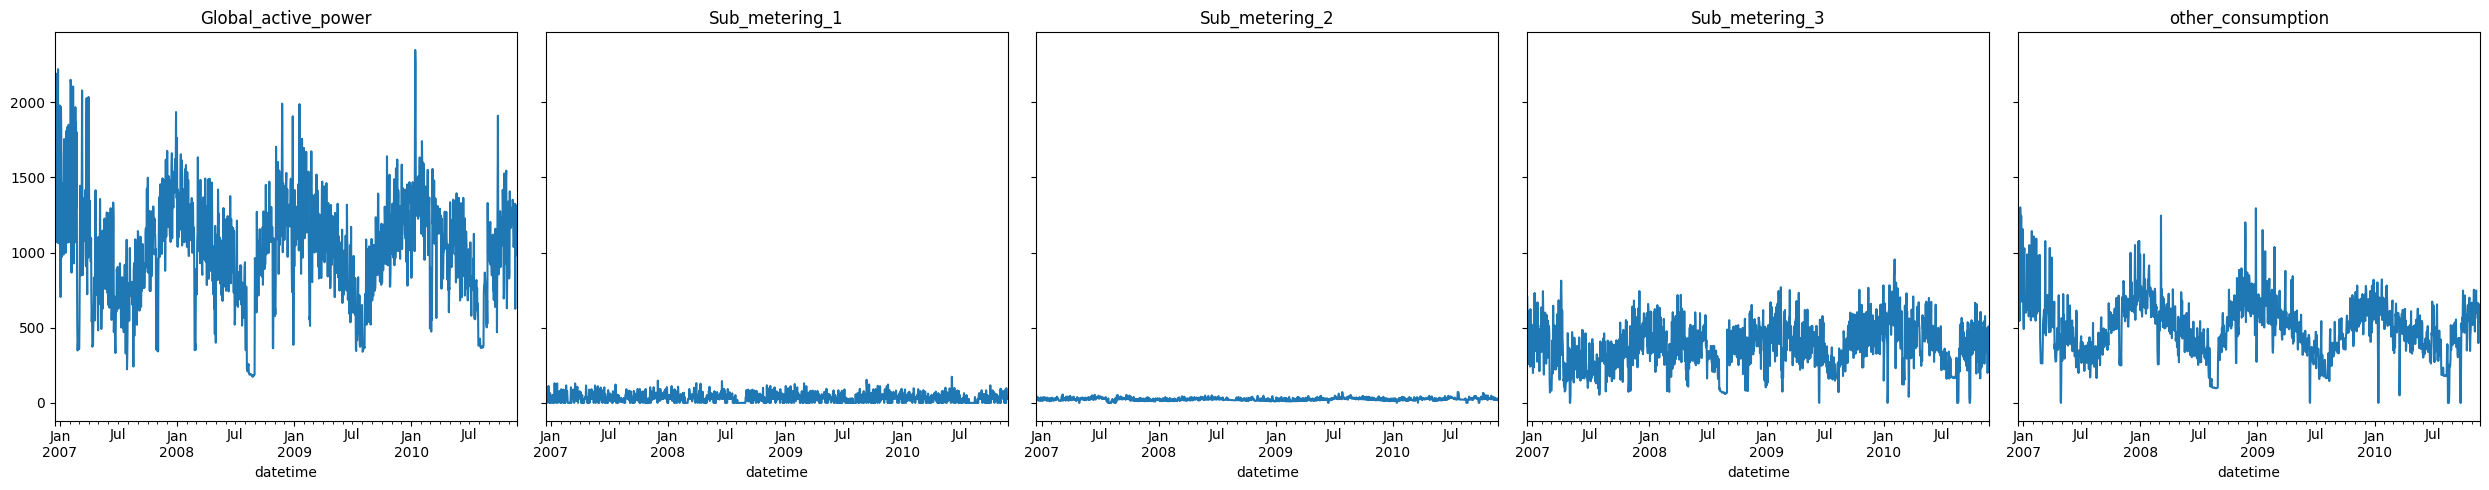

In [133]:
plot_all_columns(df)

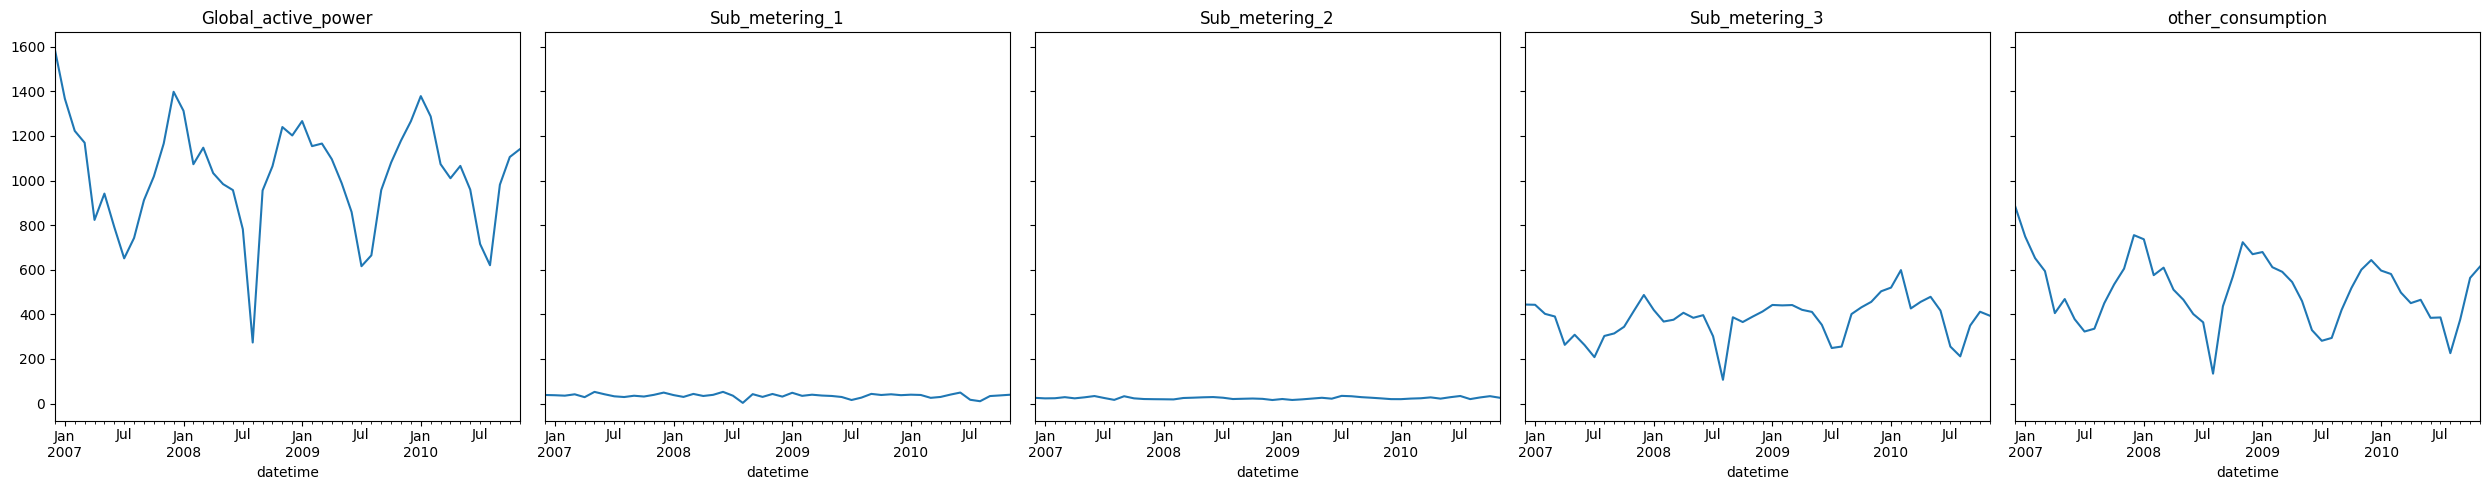

In [134]:
plot_all_columns(df, rule='ME')

In [135]:
def print_and_plot_acf(time_series):
    sm.graphics.tsa.plot_acf(time_series)
    plt.show()
    
def print_and_plot_pacf(time_series):
    sm.graphics.tsa.plot_pacf(time_series)
    plt.show()

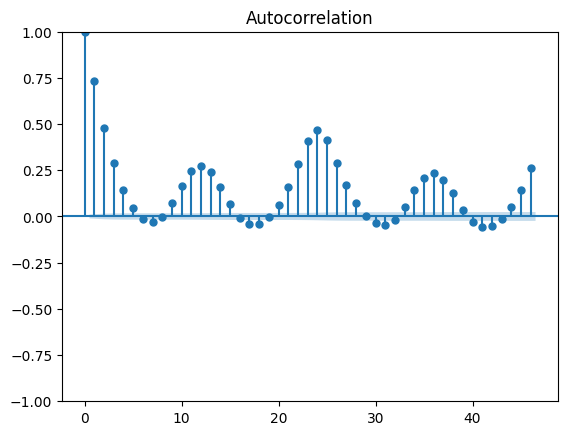

In [136]:
print_and_plot_acf(df['Global_active_power'])

we can see that there is high correlation after 12 and much higher after 24 which is accurate for hourly data

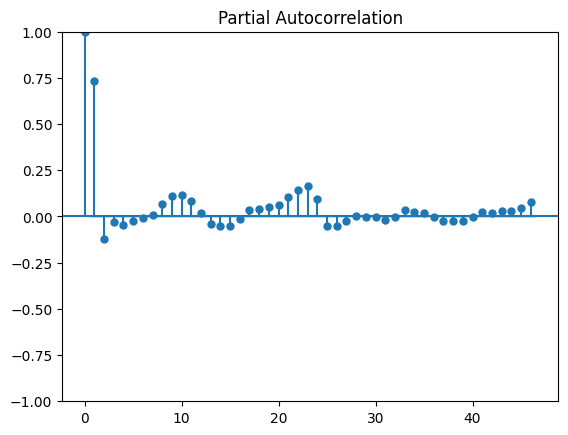

In [137]:
print_and_plot_pacf(df['Global_active_power'])

# resample Daily Vs 1 month decomposition

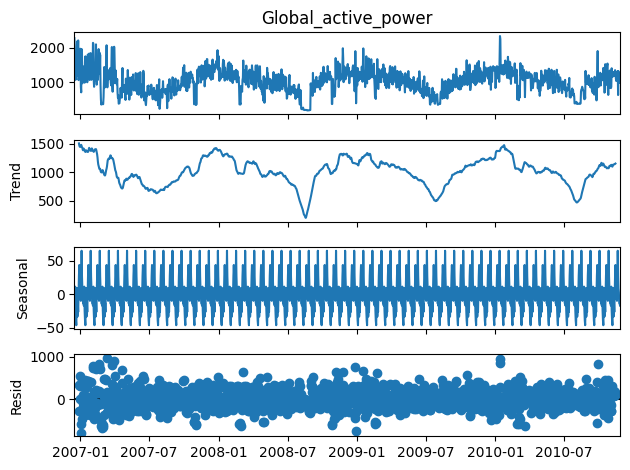

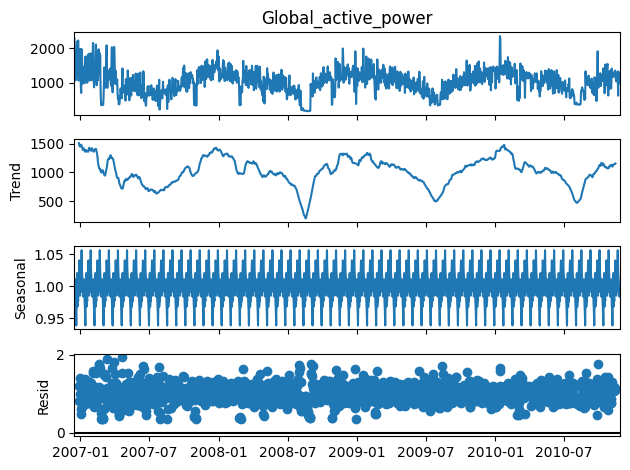

In [138]:
from statsmodels.tsa.seasonal import seasonal_decompose


daily_df = df.resample(rule='D').mean()

additive_model = seasonal_decompose(daily_df['Global_active_power'], model='additive', 
                                    period=24)

additive_model.plot()
plt.show()


multiplicative_model = seasonal_decompose(daily_df['Global_active_power'], model='multiplicative', 
                                    period=24)

multiplicative_model.plot()
plt.show()

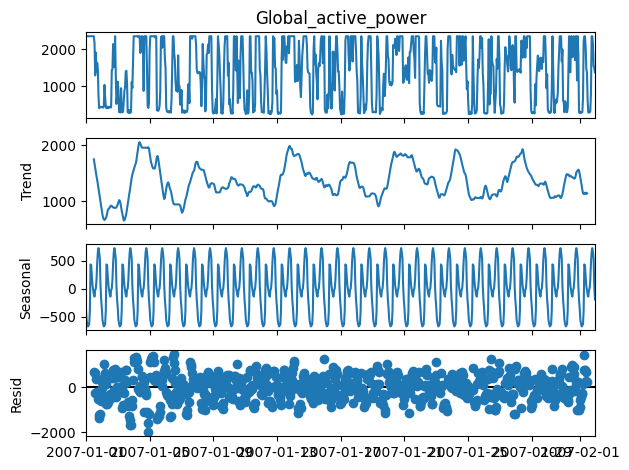

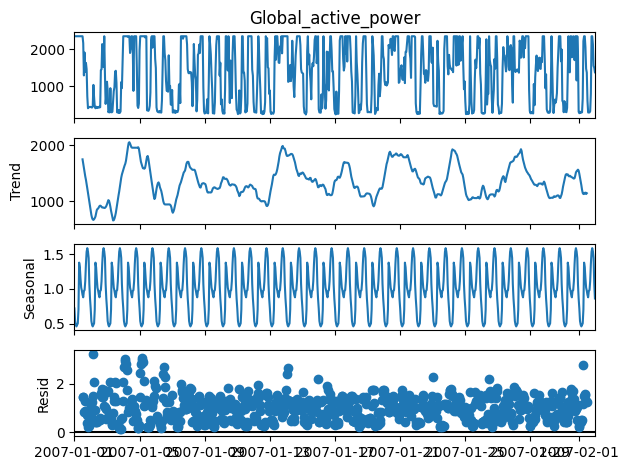

In [139]:
df_1month = df['2007-01-01':'2007-02-01']

additive_model = seasonal_decompose(df_1month['Global_active_power'], model='additive', 
                                    period=24)

additive_model.plot()
plt.show()


multiplicative_model = seasonal_decompose(df_1month['Global_active_power'], model='multiplicative', 
                                    period=24)

multiplicative_model.plot()
plt.show()

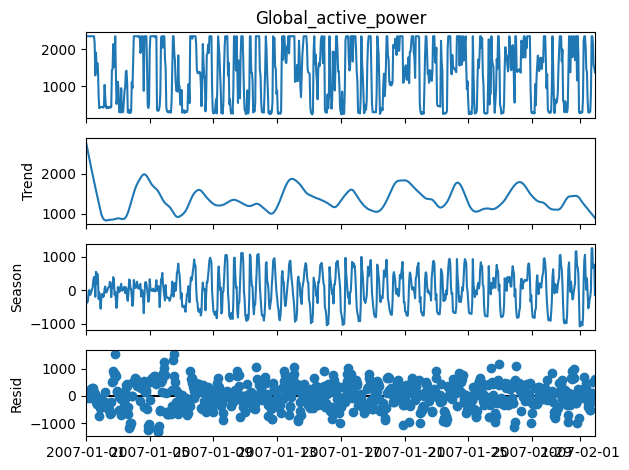

In [140]:
from statsmodels.tsa.seasonal import STL

stl_result = STL(df_1month['Global_active_power']).fit()
stl_result.plot()
plt.show()

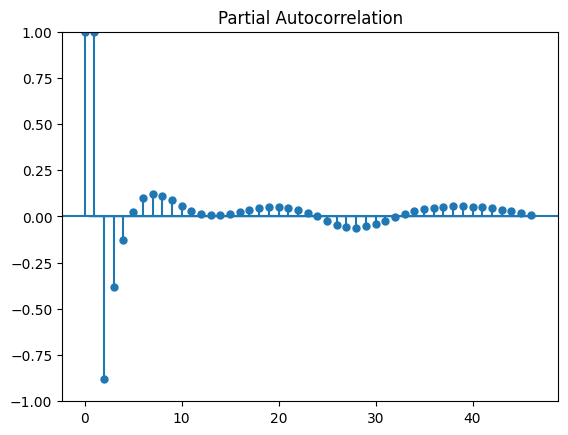

In [141]:
stl_result = STL(df['Global_active_power']).fit()
print_and_plot_pacf(stl_result.trend)
# AR(1)

### **Why Compute PACF on STL Trend Component?**  

1. **Purpose**  
   - The trend component captures long-term movements in the time series.
   - The **STL decomposition** extracts the **trend** from a time series.  
   - The **PACF (Partial Autocorrelation Function)** helps analyze the trend's autoregressive (AR) structure.  

2. **Key Insights from PACF on Trend**  
   - **Identifies AR Process**:  
     - A significant spike at lag *k* suggests an **AR(k)** model for the trend.  
     - Example: A spike at lag 1 → trend follows **AR(1)**
   - **Detects Non-Stationarity**:  
     - Slow PACF decay → trend may need **differencing** (e.g., use `df['trend'].diff()`).  
   - **Residual Seasonality Check**:  
     - Spikes at seasonal lags (e.g., 24 for hourly data) → STL may need tuning.  

3. **Next Steps**  
   - If **stationary**: Fit an **AR model** (e.g., `ARIMA(p,0,0)`).  
   - If **non-stationary**: Apply differencing and recheck PACF.  
   - If **flat trend**: Model may not need complex trend handling.  

### **Why Work on the Trend Component Instead of the Raw Data?**  

When decomposing a time series using **STL (Seasonal-Trend Decomposition using LOESS)**, we split the data into three parts:  
1. **Trend** (\(T_t\)) → Long-term movement.  
2. **Seasonal** (\(S_t\)) → Repeating patterns (e.g., daily, weekly).  
3. **Residual** (\(R_t\)) → Noise/irregular fluctuations.  

#### **Why Analyze the Trend Separately?**  
1. **Removes Seasonality & Noise**  
   - The raw data may have strong **seasonality** and **random noise**, making trend analysis difficult.  
   - By isolating the trend, we focus purely on **long-term behavior** (e.g., increasing/decreasing patterns).  

2. **Helps in Model Selection**  
   - Many forecasting models (e.g., **ARIMA**) assume **stationarity** (constant mean/variance).  
   - The **trend component** often contains **non-stationarity** (e.g., upward/downward drift).  
   - Differencing the trend (instead of raw data) ensures we only remove **trend-based non-stationarity**, not seasonality.  

3. **Avoids Over-Differencing**  
   - Differencing the **raw data** may remove **both trend and seasonality**, leading to **loss of information**.  
   - Differencing **only the trend** is more precise.  

4. **Better Interpretability**  
   - The trend is smoother and easier to model (e.g., with **AR models**).  
   - After modeling the trend, we can **recombine** it with seasonality and residuals for final forecasts.  

---

### **When Should You Work on Raw Data Instead?**  
1. **If Seasonality is Weak** → Differencing raw data may suffice.  
2. **For Simpler Models** (e.g., Exponential Smoothing) → They handle trend + seasonality together.  
3. **If Trend is Already Stationary** → No need to decompose.  



In [142]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, max_diff=2):
    current_diff = 0
    while current_diff <= max_diff:
        if current_diff > 0:
            series_diff = series.diff(current_diff).dropna()
        else:
            series_diff = series.copy()
        
        adf_result = adfuller(series_diff)
        p_value = adf_result[1]
        
        print(f"Diff Order = {current_diff}, p-value = {p_value:.4f}")
        if p_value <= 0.05:
            print("✅ Series is stationary (reject H₀)")
            return current_diff
        current_diff += 1
    print("❌ Series may still be non-stationary after max_diff")
    return max_diff

d_needed = check_stationarity(stl_result.trend)
print(f"Required differences (d): {d_needed}")

Diff Order = 0, p-value = 0.0000
✅ Series is stationary (reject H₀)
Required differences (d): 0


so we think the d = 0 and we know that our data is stationary for intuition we the consumtion didn't increase over the 4 years

In [158]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming df is your main DataFrame with a DateTimeIndex and 'Global_active_power' column
# Use the last 2 years of the data
last_two_years_start = df.index.max() - pd.DateOffset(years=2)
last_half_df = df.loc[df.index >= last_two_years_start, 'Global_active_power']

# Load weather data with datetime index
weather_data = pd.read_csv('Sceaux_hourly_weather_2006_2010.csv', index_col='date')
weather_data.index = pd.to_datetime(weather_data.index)
print(weather_data.isna().sum())


temperature_2m          0
relative_humidity_2m    0
dtype: int64


In [164]:

# Align weather data to the same timestamps as last_half_df
# Reindex weather_data to last_half_df's index to ensure all timestamps are present
weather_exog = weather_data.reindex(last_half_df.index)[['temperature_2m', 'relative_humidity_2m']]
# Interpolate any missing values
weather_exog = weather_exog.interpolate(method='time')
weather_exog.head()

,temperature_2m,relative_humidity_2m
datetime,,
2008-11-26 21:00:00,3.3,94.0
2008-11-26 22:00:00,3.6,94.0
2008-11-26 23:00:00,3.6,94.0
2008-11-27 00:00:00,3.7,93.0
2008-11-27 01:00:00,3.8,92.0


In [165]:
weather_exog.isna().sum()

temperature_2m          0
relative_humidity_2m    0
dtype: int64

In [166]:
# Define and fit SARIMAX model
model = SARIMAX(last_half_df, 
                exog=weather_exog,
                order=(1, 0, 1),
                seasonal_order=(1, 0, 1, 24),
                freq='h')

sarimax_result = model.fit(disp=False)

# Save the fitted model for production use
sarimax_result.save('sarimax_model.pkl')

print("Model training complete and saved as 'sarimax_model.pkl'")


d:\trying\applayed\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
d:\trying\applayed\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model training complete and saved as 'sarimax_model.pkl'


                                     SARIMAX Results                                      
Dep. Variable:                Global_active_power   No. Observations:                17521
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood             -131205.758
Date:                            Sat, 17 May 2025   AIC                         262425.516
Time:                                    00:06:08   BIC                         262479.914
Sample:                                11-26-2008   HQIC                        262443.428
                                     - 11-26-2010                                         
Covariance Type:                              opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
temperature_2m          -6.0848      2.201     -2.764      0.006     -10.399      -1.771
relat

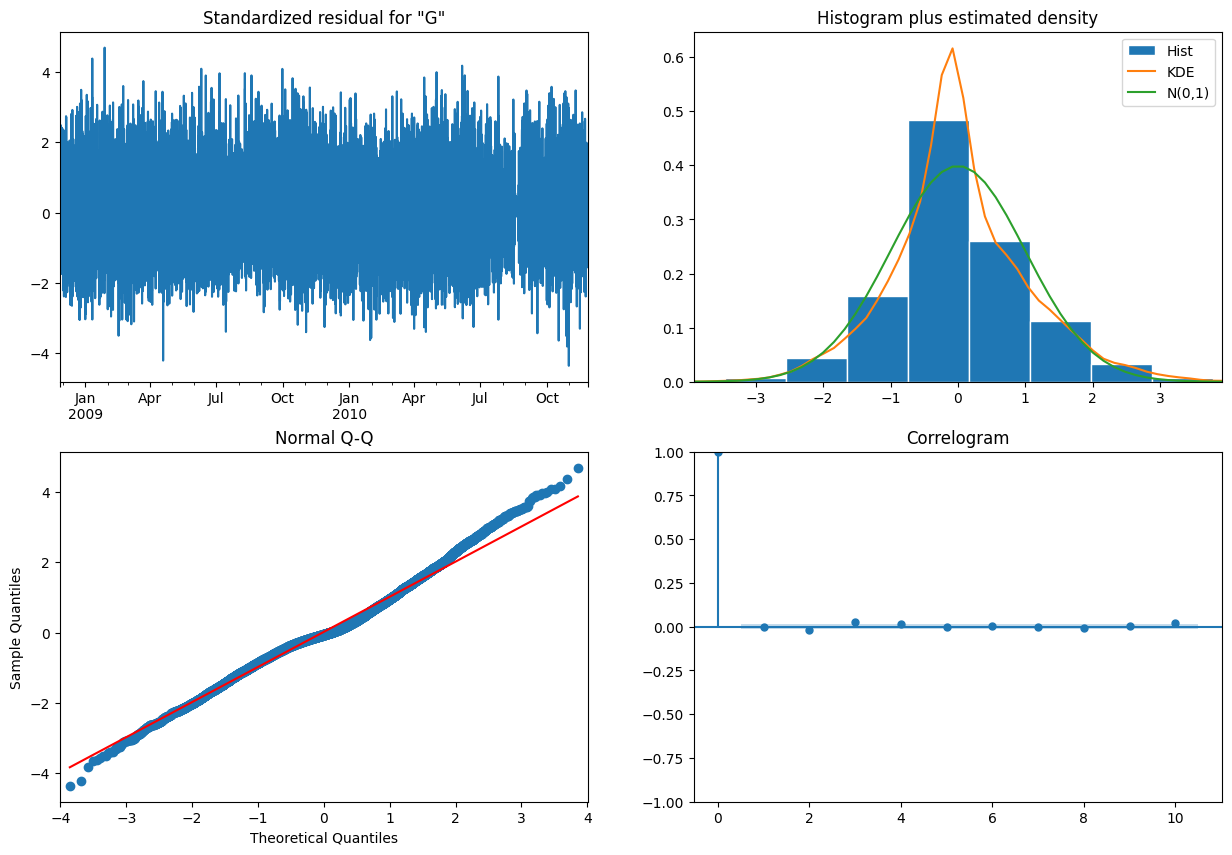

In [167]:
# Print summary
print(sarimax_result.summary())

sarimax_result.plot_diagnostics(figsize=(15, 10))
plt.show()


# Forecast


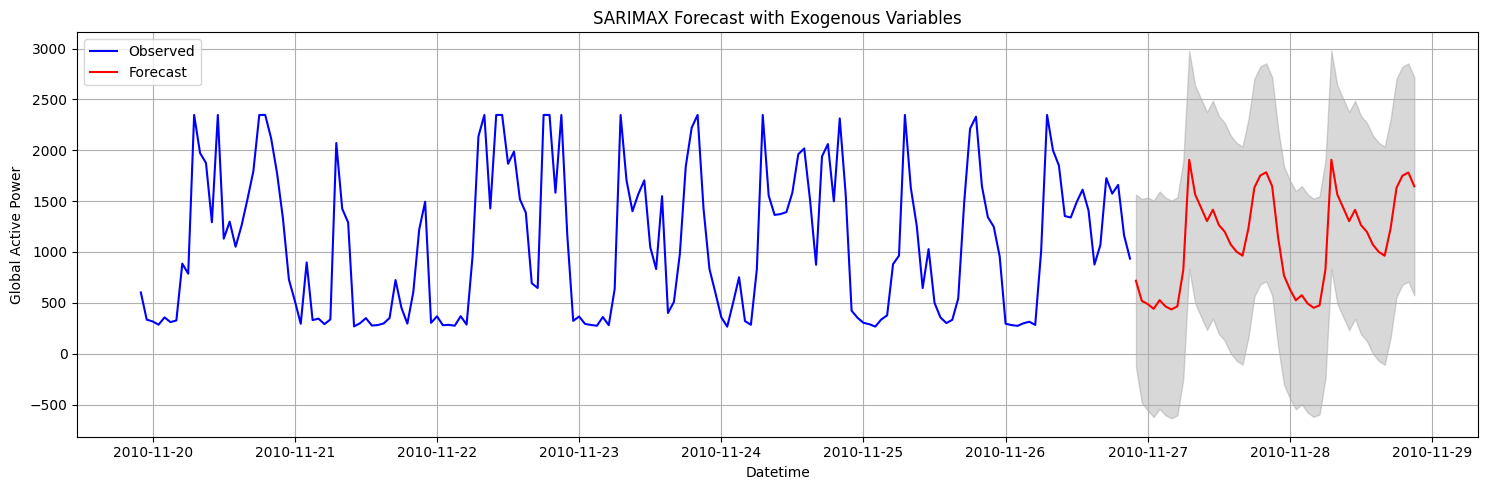

In [171]:
# Set forecast horizon
forecast_steps = 24 * 2

# Create future datetime index
last_timestamp = last_half_df.index[-1]
future_index = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), periods=forecast_steps, freq='h')
# Repeat the last 24 hours of weather data to use as future exog
recent_weather = weather_exog[-24:]
future_exog = pd.concat([recent_weather] * (forecast_steps // 24 + 1), ignore_index=True).iloc[:forecast_steps]
future_exog.index = future_index

# Forecast future target values
forecast = sarimax_result.get_forecast(steps=forecast_steps, exog=future_exog)

# Extract forecasted values and confidence intervals
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

plt.figure(figsize=(15, 5))
plt.plot(last_half_df[-7*24:], label='Observed', color='blue')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3)
plt.xlabel('Datetime')
plt.ylabel('Global Active Power')
plt.title('SARIMAX Forecast with Exogenous Variables')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


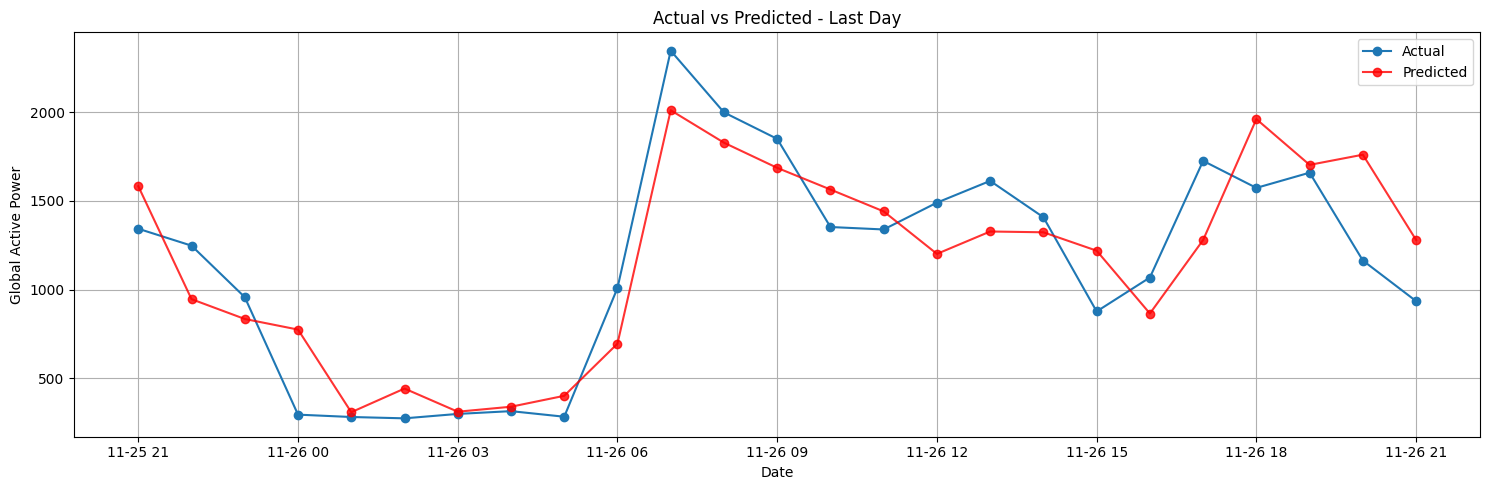

In [170]:
last_month_start = last_half_df.index.max() - pd.DateOffset(days=1)
pred_index = last_half_df.loc[last_month_start:].index

# Check the length again
exog_last_month = weather_exog.loc[last_month_start:]
# Now predict
predicted = sarimax_result.predict(start=last_month_start, end=last_half_df.index.max(), exog=exog_last_month)


plt.figure(figsize=(15, 5))
plt.plot(last_half_df.loc[last_month_start:], label='Actual', marker='o')
plt.plot(predicted, label='Predicted', color='red', marker='o', alpha=0.8)
plt.title('Actual vs Predicted - Last Day')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Why we sucked before
because the data is very large and have many samples the predection over big periods of time result in bad forcasting and fitting also is bad so if you didn't need that low level sampling you can use day or even month sample 

# Try Semi-Arima
which we use the model we want and choose ranges of param to work with

In [ ]:
# from itertools import product
# import pandas as pd
# import numpy as np
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from sklearn.metrics import mean_squared_error

# last_third_df = df.iloc[-len(df) // 3:]['Global_active_power']


# # Define the range of parameters
# q = range(1, 2)  # p, d, q from 0 to 2
# d = [1]
# p = range(1, 2)  # p, d, q from 0 to 2

# P = [1, 2]
# D = [0]
# Q = [1, 2]
# s = 24  # Seasonal period (e.g., 24 for hourly data)

# # Generate all combinations of parameters
# param_combinations = list(product(p, d, q, P, D, Q))

# # Initialize variables to store the best parameters and lowest error
# best_params = None
# lowest_error = 184196.2082516708

# # Iterate over all parameter combinations
# for params in param_combinations:
#     try:
#         # Unpack parameters
#         order = (params[0], params[1], params[2])
#         seasonal_order = (params[3], params[4], params[5], s)
        
#         # Define and fit the SARIMAX model
#         model = SARIMAX(last_third_df, order=order
#                         , seasonal_order=seasonal_order
#                         , freq='h',
#                             enforce_stationarity=False,
#                             enforce_invertibility=False)
#         result = model.fit(disp=False)
        
#         # Calculate the mean squared error
#         predictions = result.predict(start=0, end=len(last_third_df) - 1)
#         error = mean_squared_error(last_third_df, predictions)
        
#         # Update the best parameters if the current error is lower
#         if error < lowest_error:
#             lowest_error = error
#             best_params = (order, seasonal_order)
#             print(f"Best Parameters: {best_params}")
#             print(f"Lowest Error: {lowest_error}")
    
#     except Exception as e:
#         # Skip invalid parameter combinations
#         continue

# # Print the best parameters and the lowest error
# print(f"Best Parameters: {best_params}")
# print(f"Lowest Error: {lowest_error}")
# # Best Parameters: ((1, 1, 1), (1, 0, 1, 24))
# # Lowest Error: 184196.2082516708

# # Best Parameters: ((1, 1, 1), (2, 0, 2, 24))
# # Lowest Error: 183953.3420290283